In [9]:
#Data load

# Packages 
import pandas as pd 
import numpy as np 
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore 
from colorama import Style
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.preprocessing import MinMaxScaler 
from sklearn.cluster import KMeans 
import matplotlib.cm as cm
from matplotlib import pyplot
from sklearn import datasets, linear_model
from sklearn.linear_model import LogisticRegression

In [11]:
# Reading raw data
raw = pd.read_csv('employee_churn_data.csv')

raw.head(9540)

,department,promoted,review,projects,salary,tenure,satisfaction,bonus,avg_hrs_month,left
0,operations,0,0.577569,3,low,5.0,0.626759,0,180.866070,no
1,operations,0,0.751900,3,medium,6.0,0.443679,0,182.708149,no
2,support,0,0.722548,3,medium,6.0,0.446823,0,184.416084,no
3,logistics,0,0.675158,4,high,8.0,0.440139,0,188.707545,no
4,sales,0,0.676203,3,high,5.0,0.577607,1,179.821083,no
...,...,...,...,...,...,...,...,...,...,...
9535,operations,0,0.610988,4,medium,8.0,0.543641,0,188.155738,yes
9536,logistics,0,0.746887,3,medium,8.0,0.549048,0,188.176164,yes
9537,operations,0,0.557980,3,low,7.0,0.705425,0,186.531008,yes
9538,IT,0,0.584446,4,medium,8.0,0.607287,1,187.641370,yes


In [12]:
# Creating raw data copy
df = raw.copy()

In [13]:
# Checking clean shape and nº of employees
rows, cols = df.shape 
departments = df.department.unique().shape[0]

print(f'Dataset Shape\n\nNumber of Employee Observations : {rows}\nNumber of features : {cols}\nNumber of different departments : {departments}')

Dataset Shape

Number of Employee Observations : 9540
Number of features : 10
Number of different departments : 10


In [14]:
# Checking general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9540 entries, 0 to 9539
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   department     9540 non-null   object 
 1   promoted       9540 non-null   int64  
 2   review         9540 non-null   float64
 3   projects       9540 non-null   int64  
 4   salary         9540 non-null   object 
 5   tenure         9540 non-null   float64
 6   satisfaction   9540 non-null   float64
 7   bonus          9540 non-null   int64  
 8   avg_hrs_month  9540 non-null   float64
 9   left           9540 non-null   object 
dtypes: float64(4), int64(3), object(3)
memory usage: 745.4+ KB


In [ ]:
# Missing values reporter function
def missing_value_reporter(data, threshold=None):
    '''Returns pandas dataframe of missing values absolute and relative frequency for each feature and 
    it's also possible to parse a threshold variable to warn if a feature is above or below the desired missing threshold limit.
    If the threshold is not provided, it defaults to None.
     Args:
        data - input for data
        threshold - input for threshold variable
        
    '''
    na_count = df.isna().sum()
    na_count = na_count[na_count > 0]
    na_abs_frq = na_count.values
    na_rel_frq = round(na_count/na_count.sum(), 2)
    missings = pd.DataFrame({'Feature': na_count.index, 'Nº of missings': na_abs_frq, '% of missings': na_rel_frq})
    missings = missings.sort_values(by = 'Nº of missings', ascending = False)
    if threshold:
        missings['Above threshold'] = [True if x > threshold else False for x in missings['% of missings']]
    return missings

missing_value_reporter(data=df, threshold=0.03)

Missing Values Conclusion

The missing values reporter seems to be is empty, so we can assume there are no missing values.

In [18]:
# Checking outliers with Z-score test

# Subseting numeric features and deleting binary for test
tmp = df.select_dtypes(include = ['float64', 'int64'])

for col, rows in tmp.items(): 
    if col in tmp:
        if rows.value_counts().shape[0] == 2:
            del tmp[col]

# Array with all observations Z-score
z = np.abs(stats.zscore(tmp))

# Defining Z-score threshold
threshold = 3.5

# 2 arrays with the row and columns indices of  respectively
outloc = np.where(z>=threshold) 
outloc

(array([3850, 5723, 5723, 6196, 6456, 7547, 7576, 7946, 8969], dtype=int64),
 array([0, 2, 4, 0, 4, 0, 0, 4, 0], dtype=int64))

In [19]:
# High Z-score values count
cols = outloc[1]

for x in np.unique(cols): 
    col = tmp.columns[x] 
    occurrences = np.count_nonzero(cols == x)
    print(f'The {Fore.LIGHTMAGENTA_EX}{col}{Style.RESET_ALL} feature has {occurrences} observations with a Z-score higher or equal to 3.5')

The review feature has 5 observations with a Z-score higher or equal to 3.5
The tenure feature has 1 observations with a Z-score higher or equal to 3.5
The avg_hrs_month feature has 3 observations with a Z-score higher or equal to 3.5


In [21]:
# Checking the 5 observations value from the column review

# Creating an array with row index of instances with high Z-score value from the review column
tmp = df['review']
z = np.abs(stats.zscore(tmp))
threshold = 3.5
sub = np.where(z>=threshold) 

# Checking review range and unique values from the 5 instances
min = df['review'].min()
max = df['review'].max() 
for i in sub: 
    print(f'The {Fore.LIGHTMAGENTA_EX}review{Style.RESET_ALL} feature ranges from {min} to {max}\n\nUnique values from the 5 {Fore.LIGHTMAGENTA_EX}review{Style.RESET_ALL} instances: {np.unique(tmp[i]).round(2)}{Style.RESET_ALL}')

The review feature ranges from 0.31 to 1.0

Unique values from the 5 review instances: [0.31 0.33 0.35 0.99 1.  ]


In [22]:
# Checking the 1 observations value from the column tenure

# Creating an array with row index of instances with high Z-score value from the tenure column
tmp = df['tenure']
z = np.abs(stats.zscore(tmp))
threshold = 3.5
sub = np.where(z>=threshold) 

# Checking the maximum years the employee has been at the company and unique values from 1 instance
max = df['tenure'].max() 
for i in sub:
    print(f' The {Fore.LIGHTMAGENTA_EX}tenure{Style.RESET_ALL} feature maximum value is {max}\n\nUnique values from the 1 {Fore.LIGHTMAGENTA_EX}tenure{Style.RESET_ALL} instance: {np.unique(tmp[i])}{Style.RESET_ALL}')


 The tenure feature maximum value is 12.0

Unique values from the 1 tenure instance: [12.]


In [23]:
# Checking the 3 observations value from the column avg_hrs_month

# Creating an array with row index of instances with high Z-score value from the avg_hrs_month column
tmp = df['avg_hrs_month']
z = np.abs(stats.zscore(tmp))
threshold = 3.5
sub = np.where(z>=threshold) 

# Checking review range and unique values from the 3 instances
min = round(df['avg_hrs_month'].min(),2)
max = round(df['avg_hrs_month'].max(),2) 
for i in sub: 
    print(f'The {Fore.LIGHTMAGENTA_EX}avg_hrs_month{Style.RESET_ALL} feature ranges from {min} to {max}\n\nUnique values from the 3 {Fore.LIGHTMAGENTA_EX}avg_hrs_month{Style.RESET_ALL} instances: {np.unique(tmp[i]).round(2)}{Style.RESET_ALL}')

The avg_hrs_month feature ranges from 171.37 to 200.86

Unique values from the 3 avg_hrs_month instances: [199.3  199.38 200.86]


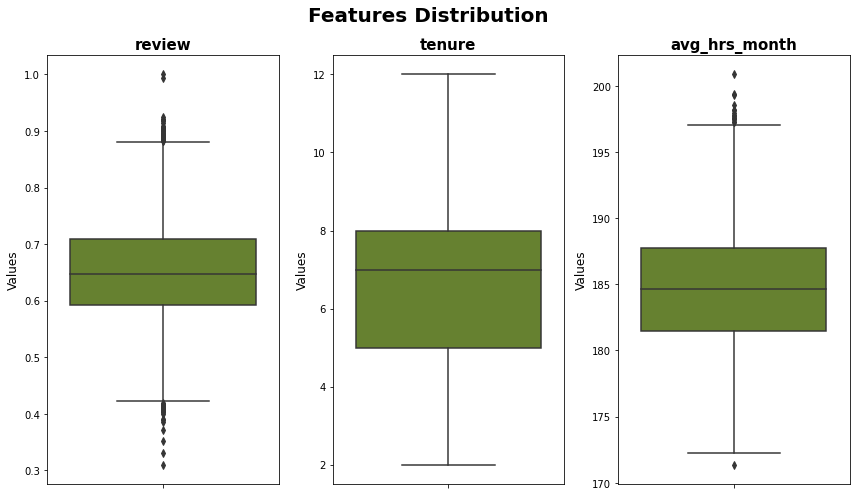

In [24]:
# Checking these features distribution visually

#subset
zscore_features = ['review', 'tenure','avg_hrs_month']

#plot and customize
fig, ax = plt.subplots(1, len(zscore_features), figsize = (12,7))

for idx, feature in enumerate(zscore_features):
    sns.boxplot(data=df,y=feature,color='olivedrab', ax=ax[idx])
    ax[idx].set_ylabel('Values', fontsize = 12)  
    ax[idx].set_xlabel('',fontsize = 12)
    ax[idx].set_title(feature, fontsize = 15, fontweight= 'bold')
    plt.sca(ax[idx]) 
        
plt.suptitle('Features Distribution', fontsize = 20, fontweight = 'bold') 
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.5, wspace=0.4, hspace=0.4)

plt.tight_layout()

Outliers Conclusion

After counting the instances with a Z-score higher or equal to the defined threshold (3.5) per column it's possible to check that the features: review (5), tenure (1) and avg_hrs_month (3) were the only ones with high Z-score observations.

The ones in review were inside the desired range (from 0 to 1), so they weren't considered outliers. As for the ones in tenure and avg_hrs_month the values were simply distant from its feature's mean. In both of these cases, the high Z-score observations were provident from their highest values but, since they seem realistic (12 years in a company and averaging around 200 hours of work per month) , they weren't considered as outliers.

AttributeError: 'DataFrame' object has no attribute 'department'

In [25]:
#Data transformation 
# Changing the columns names to title text
df.columns = [i.title() for i in df.columns]

# Changing the text feature's values to capitalized text
df[['Department','Salary','Left']] = df[['Department','Salary','Left']].apply(lambda x: x.str.capitalize())

# Changing Left feature to binary 
df['Left'] = df['Left'].apply(lambda x: 0 if x == 'No' else 1)

# Changing Salary feature to numerical 
df['Salary'] = df['Salary'].apply(lambda x: 1 if x == 'Low' else (2 if x == 'Medium' else 3))

# Rounding Review, Satisfaction and Avg_Hrs_Month
df[['Review','Satisfaction','Avg_Hrs_Month']] = df[['Review','Satisfaction','Avg_Hrs_Month']].apply(lambda x: round(x,2))

df.head()

,Department,Promoted,Review,Projects,Salary,Tenure,Satisfaction,Bonus,Avg_Hrs_Month,Left
0,Operations,0,0.58,3,1,5.0,0.63,0,180.87,0
1,Operations,0,0.75,3,2,6.0,0.44,0,182.71,0
2,Support,0,0.72,3,2,6.0,0.45,0,184.42,0
3,Logistics,0,0.68,4,3,8.0,0.44,0,188.71,0
4,Sales,0,0.68,3,3,5.0,0.58,1,179.82,0


Exploratory Data Analysis

Getting a better understanding of data

Identifying various data patterns

Getting a better understanding of the problem statement

In [26]:
# Summary statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Promoted,9540.0,0.030294,0.171403,0.00,0.00,0.00,0.00,1.00
Review,9540.0,0.651843,0.085318,0.31,0.59,0.65,0.71,1.00
Projects,9540.0,3.274843,0.579136,2.00,3.00,3.00,4.00,5.00
Salary,9540.0,2.017505,0.553849,1.00,2.00,2.00,2.00,3.00
Tenure,9540.0,6.556184,1.415432,2.00,5.00,7.00,8.00,12.00
Satisfaction,9540.0,0.504617,0.158583,0.00,0.39,0.50,0.62,1.00
Bonus,9540.0,0.212055,0.408785,0.00,0.00,0.00,0.00,1.00
Avg_Hrs_Month,9540.0,184.661551,4.144797,171.37,181.47,184.63,187.73,200.86
Left,9540.0,0.291824,0.454626,0.00,0.00,0.00,1.00,1.00


In [27]:
# Original object features statistics 
raw.describe(include='O')

,department,salary,left
count,9540,9540,9540
unique,10,3,2
top,sales,medium,no
freq,1883,6611,6756


In [28]:
# Checking median and mode from numerical features
tmp = df.select_dtypes(include = ['float64', 'int64']) 

for col in tmp.columns: 
    print(f'{col} median :',tmp[col].median())
    print(f'{col} mode :',tmp[col].mode()[0],'\n')

Promoted median : 0.0
Promoted mode : 0 

Review median : 0.65
Review mode : 0.64 

Projects median : 3.0
Projects mode : 3 

Salary median : 2.0
Salary mode : 2 

Tenure median : 7.0
Tenure mode : 6.0 

Satisfaction median : 0.5
Satisfaction mode : 0.43 

Bonus median : 0.0
Bonus mode : 0 

Avg_Hrs_Month median : 184.63
Avg_Hrs_Month mode : 187.24 

Left median : 0.0
Left mode : 0 



In [29]:
# Setting Style 
plt.style.use('seaborn')

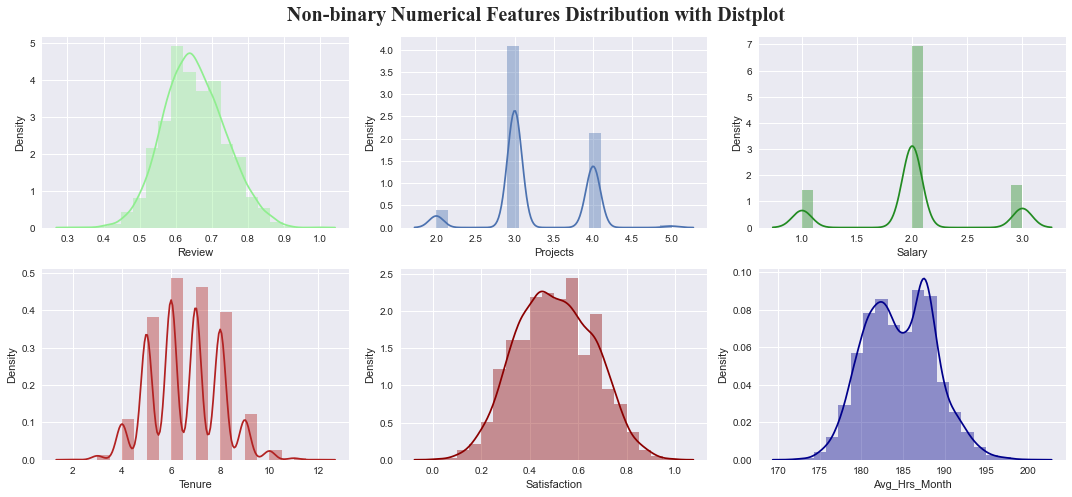

In [30]:
# Numeric features distribution (non-binary)

#subseting numeric features and deleting binary for viz
tmp = df.select_dtypes(include = ['float64', 'int64'])

for col, rows in tmp.items(): 
    if col in tmp:
        if rows.value_counts().shape[0] == 2:
            del tmp[col]
            
#plot

fig, ax = plt.subplots(2, 3, figsize = (15,7)) 

sns.distplot(tmp.iloc[:,0], bins=20, hist_kws={'alpha': 0.4}, color='lightgreen', ax = ax[0,0])
sns.distplot(tmp.iloc[:,1],  bins=20, hist_kws={'alpha': 0.4}, ax = ax[0,1]) 
sns.distplot(tmp.iloc[:,2], bins=20, hist_kws={'alpha': 0.4}, color='forestgreen', ax = ax[0,2])
sns.distplot(tmp.iloc[:,3],  bins=20, hist_kws={'alpha': 0.4}, color='firebrick', ax = ax[1,0]) 
sns.distplot(tmp.iloc[:,4], bins=20, hist_kws={'alpha': 0.4}, color='darkred', ax = ax[1,1])  
sns.distplot(tmp.iloc[:,5], bins=20, hist_kws={'alpha': 0.4}, color='darkblue', ax = ax[1,2])

#customize
plt.rcParams['font.family'] = 'Times New Roman'
plt.suptitle('Non-binary Numerical Features Distribution with Distplot', fontsize = 20, fontweight = 'bold') 
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None) 
        

plt.tight_layout()

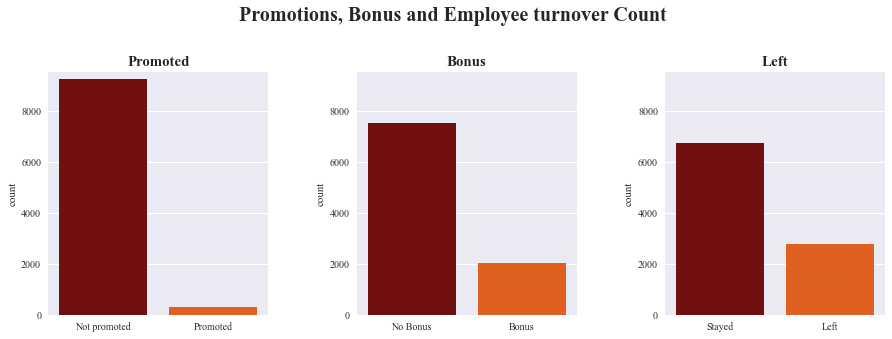


Nº of Promotions : 289 from 9540 employees( 3.03 %) 
Nº of Bonuses : 2023 from 9540 employees( 21.21 %) 
Nº of employee turnovers : 2784 from 9540 employees( 29.18 %)


In [31]:
# Promotions, bonus and employee turnover count
#plot
fig, ax = plt.subplots(1, 3, figsize = (15,5)) 

sns.countplot(data=df,x='Promoted', ax = ax[0], palette= 'gist_heat')
sns.countplot(data=df,x='Bonus', ax = ax[1], palette= 'gist_heat')
sns.countplot(data=df,x='Left', ax = ax[2], palette= 'gist_heat')

#customize
plt.rcParams['font.family'] = 'Times New Roman'
plt.suptitle('Promotions, Bonus and Employee turnover Count',fontsize = 20, fontweight = 'bold')
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.8, wspace=0.4, hspace=None) 


for i in range(3): 
    ax[i].set_ylim(0,len(df))
    ax[i].set_xlabel('')
    plt.sca(ax[i])
    if i == 0: 
        ax[i].set_xticklabels({'Not promoted':0,'Promoted':1})
        ax[i].set_title('Promoted' ,fontsize = 15, fontweight = 'bold')
    elif i == 1: 
        ax[i].set_xticklabels({'No Bonus':0,'Bonus':1})
        ax[i].set_title('Bonus' ,fontsize = 15, fontweight = 'bold')
    else: 
        ax[i].set_xticklabels({'Stayed':0,'Left':1})
        ax[i].set_title('Left' ,fontsize = 15, fontweight = 'bold')
    
plt.show()

#Number of promotions and bonuses
print('\nNº of Promotions :',len(df.loc[df['Promoted'].isin([1])]),'from',len(df),
      'employees(',round(len(df.loc[(df['Promoted'].isin([1]))])* 100 / len(df),2),'%)', 
      '\nNº of Bonuses :',len(df.loc[df['Bonus'].isin([1])]),'from',len(df),
      'employees(',round(len(df.loc[(df['Bonus'].isin([1]))])* 100 / len(df),2),'%)', 
      '\nNº of employee turnovers :',len(df.loc[df['Left'].isin([1])]),'from',len(df),
      'employees(',round(len(df.loc[(df['Left'].isin([1]))])* 100 / len(df),2),'%)')

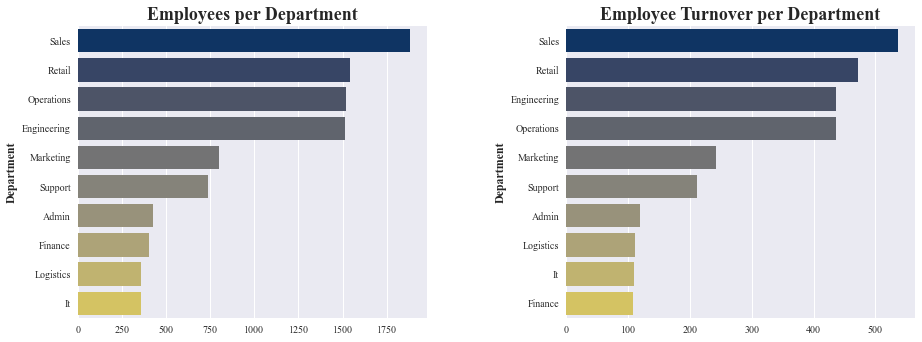

In the Operations Department:

Nº of Turnovers: 436 from 1522 employees (28.65%)

In the Support Department:

Nº of Turnovers: 212 from 735 employees (28.84%)

In the Logistics Department:

Nº of Turnovers: 111 from 360 employees (30.83%)

In the Sales Department:

Nº of Turnovers: 537 from 1883 employees (28.52%)

In the It Department:

Nº of Turnovers: 110 from 356 employees (30.9%)

In the Admin Department:

Nº of Turnovers: 119 from 423 employees (28.13%)

In the Engineering Department:

Nº of Turnovers: 437 from 1516 employees (28.83%)

In the Marketing Department:

Nº of Turnovers: 243 from 802 employees (30.3%)

In the Finance Department:

Nº of Turnovers: 108 from 402 employees (26.87%)

In the Retail Department:

Nº of Turnovers: 471 from 1541 employees (30.56%)



In [32]:
# Employee turnover per department
#subset 
tmp = df.groupby('Department', as_index=False)[['Left']].count().sort_values('Left', ascending=False) 
tmp1 = df.groupby('Department', as_index=False)[['Left']].sum().sort_values('Left', ascending=False) 

#plot
fig, ax = plt.subplots(1,2,figsize = (15, 6))

sns.barplot(data=tmp,y='Department', x='Left', palette= 'cividis', ax=ax[0])
sns.barplot(data=tmp1,y='Department', x='Left', palette= 'cividis', ax=ax[1])

#customize 
plt.rcParams['font.family'] = 'Times New Roman'
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.8, wspace=0.4, hspace=None) 

for i in range(2): 
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Department',fontsize = 12, fontweight = 'bold')
    
ax[0].set_title('Employees per Department',fontsize = 18, fontweight = 'bold') 
ax[1].set_title('Employee Turnover per Department',fontsize = 18, fontweight = 'bold')

plt.show()

#Number of turnovers and employees
for i in df['Department'].unique(): 
    turnovers = len(df.loc[(df['Department']==i) & df['Left']==1])
    employees = len(df.loc[df['Department']==i])
    print(f'In the {Fore.GREEN}{i}{Style.RESET_ALL}',
         f'Department:\n\nNº of Turnovers: {Fore.RED}{turnovers}{Style.RESET_ALL}',
         'from', employees, f'employees ({round(turnovers/employees*100,2)}%)\n')

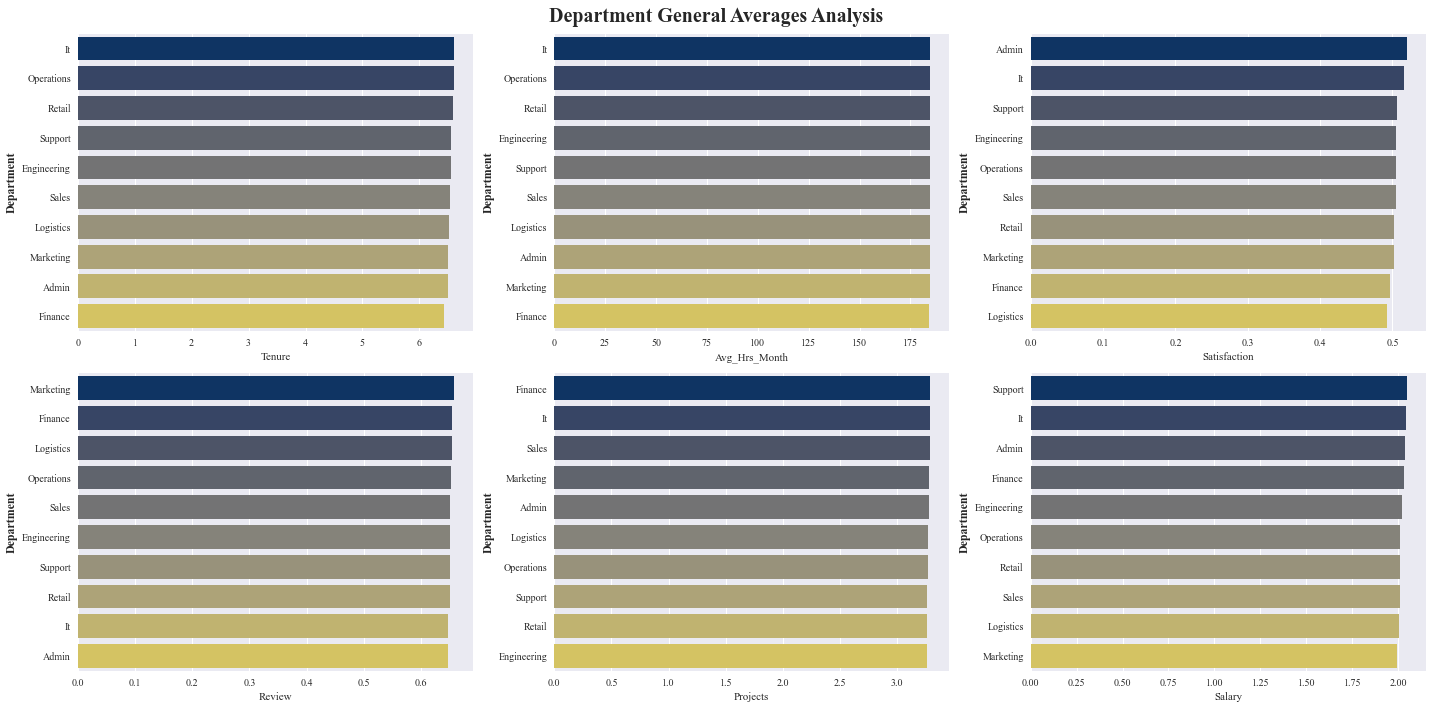

In [33]:
# Employee general average analysis per department
#subset 
tmp = df.groupby('Department', as_index=False)[['Tenure']].mean().sort_values('Tenure', ascending=False) 
tmp1 = df.groupby('Department', as_index=False)[['Avg_Hrs_Month']].mean().sort_values('Avg_Hrs_Month', ascending=False)
tmp2 = df.groupby('Department', as_index=False)[['Satisfaction']].mean().sort_values('Satisfaction', ascending=False)  
tmp3 = df.groupby('Department', as_index=False)[['Review']].mean().sort_values('Review', ascending=False) 
tmp4 = df.groupby('Department', as_index=False)[['Projects']].mean().sort_values('Projects', ascending=False) 
tmp5 = df.groupby('Department', as_index=False)[['Salary']].mean().sort_values('Salary', ascending=False)

#plot
fig, ax = plt.subplots(2,3, figsize=(20,10))

sns.barplot(data=tmp,y='Department', x='Tenure', palette= 'cividis', ax=ax[0,0])
sns.barplot(data=tmp1,y='Department', x='Avg_Hrs_Month', palette= 'cividis', ax=ax[0,1])
sns.barplot(data=tmp2,y='Department', x='Satisfaction', palette= 'cividis', ax=ax[0,2])
sns.barplot(data=tmp3,y='Department', x='Review', palette= 'cividis', ax=ax[1,0])
sns.barplot(data=tmp4,y='Department', x='Projects', palette= 'cividis', ax=ax[1,1])
sns.barplot(data=tmp5,y='Department', x='Salary', palette= 'cividis', ax=ax[1,2])


#customize 
plt.rcParams['font.family'] = 'Times New Roman'
plt.subplots_adjust(left=None, bottom=None, right=None, top=0.8, wspace=0.4, hspace=None) 

for row in range(2): 
    for col in range(3): 
        ax[row,col].set_ylabel('Department',fontsize = 12, fontweight = 'bold')

plt.suptitle('Department General Averages Analysis', fontsize = 20, fontweight = 'bold')

plt.tight_layout()

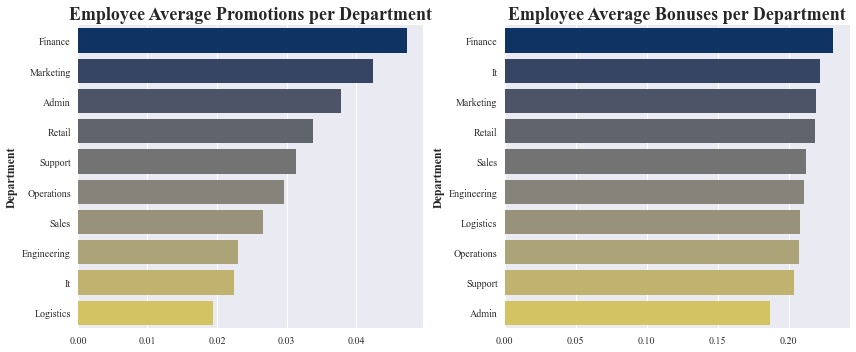

In [34]:
# Employee average promotions and bonuses per department
#subset 
tmp = df.groupby('Department', as_index=False)[['Promoted']].mean().sort_values('Promoted', ascending=False) 
tmp1 = df.groupby('Department', as_index=False)[['Bonus']].mean().sort_values('Bonus', ascending=False) 
#plot
fig, ax = plt.subplots(1,2,figsize = (12, 5))

sns.barplot(data=tmp,y='Department', x='Promoted', palette= 'cividis', ax=ax[0])
sns.barplot(data=tmp1,y='Department', x='Bonus', palette= 'cividis', ax=ax[1])

#customize 
plt.rcParams['font.family'] = 'Times New Roman'
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.4, hspace=None) 

for i in range(2): 
    ax[i].set_xlabel('')
    ax[i].set_ylabel('Department',fontsize = 12, fontweight = 'bold')
    
ax[0].set_title('Employee Average Promotions per Department',fontsize = 18, fontweight = 'bold') 
ax[1].set_title('Employee Average Bonuses per Department',fontsize = 18, fontweight = 'bold')

plt.tight_layout()

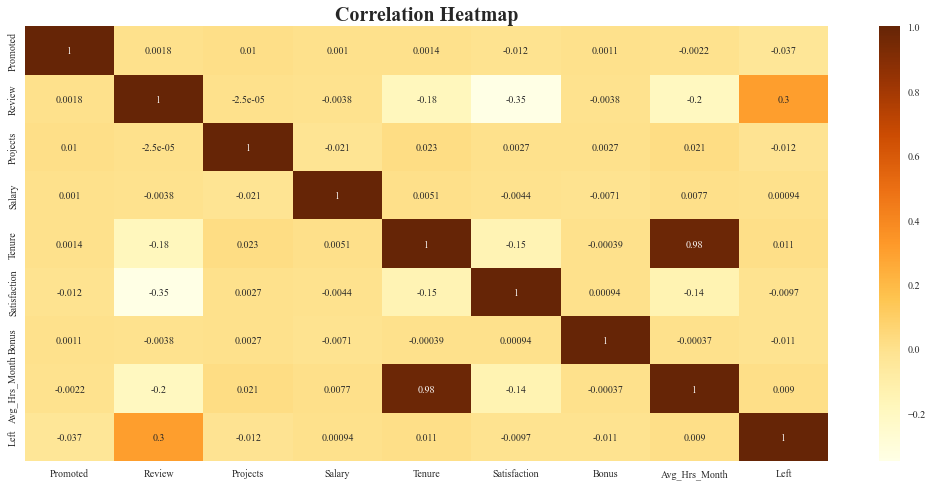

The features Avg_Hrs_Month and Tenure presented 0.98 of correlation value, meaning there´s a positive correlation that confers a very strong relationship in which variables increase or decrease simultaneously to each other.

The features Review and Satisfaction presented -0.35 of correlation value, meaning there´s a negative correlation that confers a moderate relationship in which variables increase or decrease inversely to each other.

The features Review and Left presented 0.3 of correlation value, meaning there´s a positive correlation that confers a moderate relationship in which variables increase or decrease simultaneously to each other.

The features Review and Avg_Hrs_Month presented -0.2 of correlation value, meaning there´s a negative correlation that confers a weak relationship in which variables increase or decrease inversely to each other.

The features Tenure and Review presented -0.18 of correlation value, meaning there´s a negative correlation that confers a weak relat

In [35]:
# Correlations analysis
#plot
cmap = sns.color_palette('YlOrBr', as_cmap=True)

plt.figure(figsize = (18, 8))
sns.heatmap(data = df.corr(), annot = True, cmap = cmap)

#customize
plt.title('Correlation Heatmap',fontsize = 20, fontweight = 'bold')

plt.show() 

#considerable correlation value (higher than 0.10 and lower than -0.10)
x = round(df['Avg_Hrs_Month'].corr(df['Tenure']),2)
y = round(df['Review'].corr(df['Satisfaction']),2)
z = round(df['Review'].corr(df['Left']),2)
m = round(df['Review'].corr(df['Avg_Hrs_Month']),2)
n = round(df['Tenure'].corr(df['Review']),2) 
b = round(df['Satisfaction'].corr(df['Avg_Hrs_Month']),2) 


#correlation dictionary from relevant features
dict = {'Avg_Hrs_Month and Tenure': x, 
    'Review and Satisfaction': y, 
    'Review and Left': z, 
    'Review and Avg_Hrs_Month': m, 
    'Tenure and Review': n,
    'Satisfaction and Avg_Hrs_Month': b}

#correlation loop
for cols, corr in dict.items():  
    
    if corr >= 0 and corr <= 0.05 or corr <= 0 and corr >= -0.05: 
        Relationship = 'no relationship' 
    elif corr >= 0.05 and corr <= 0.25 or corr <= -0.05 and corr >= -0.25: 
        Relationship = 'weak relationship' 
    elif corr > 0.25 and corr <= 0.50 or corr < -0.25 and corr >= -0.50 : 
        Relationship = 'moderate relationship' 
    elif corr > 0.50 and corr <= 0.75 or corr < -0.50 and corr >= -0.75 : 
        Relationship = 'strong relationship' 
    else: 
        Relationship = 'very strong relationship' 
    if corr > 0.05 : 
        Correlation = 'positive correlation' 
        Behavior = 'simultaneously to each other'
    elif corr < 0: 
        Correlation = 'negative correlation' 
        Behavior = 'inversely to each other'
    else: 
        Correlation = 'no correlation'
        Behavior = 'indenpendently to each other' 

    print(f'The features {Fore.GREEN}{cols}{Style.RESET_ALL} presented {Fore.RED}{corr}{Style.RESET_ALL} of correlation value, meaning there´s a {Fore.YELLOW}{Correlation}{Style.RESET_ALL} that confers a {Fore.CYAN}{Relationship}{Style.RESET_ALL} in which variables increase or decrease {Fore.LIGHTMAGENTA_EX}{Behavior}{Style.RESET_ALL}.\n')